In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import starfile

In [2]:
from scipy.spatial import ConvexHull
def point_in_ConvexHull(hull, pnt):
    '''
    Checks if `pnt` is inside the convex hull.
    `hull` -- a QHull ConvexHull object
    `pnt` -- point array of shape (3,)
    '''
    new_hull = ConvexHull(np.concatenate((hull.points, [pnt])))
    if np.array_equal(new_hull.vertices, hull.vertices): 
        return True
    return False

In [3]:
preclass_particle_star_path = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/preclass_job282_run_data.star")
postclass_particle_star_path = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/postclass_job292_run_data.star")


binning = 10
tomo_dir = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/surfaces_10tomos/")
max_x = 818 * binning
max_y = 1152 * binning
max_z = 480 * binning
unbinned_pixel_size = 1.0825


Extending z interface by 277.14 px


In [116]:
preclass_particle_star = starfile.read(preclass_particle_star_path)
postclass_particle_star = starfile.read(postclass_particle_star_path)
preclass_particle_df = preclass_particle_star["particles"]
postclass_particle_df = postclass_particle_star["particles"]

topboundary_points = [
    [0, 0, max_z],
    [0, max_y, max_z],
    [max_x, 0, max_z],
    [max_x, max_y, max_z]
]
topboundary_points_df = pd.DataFrame(topboundary_points, columns=["x", "y", "z"])
bottomboundary_points = [
    [0, 0, 0],
    [0, max_y, 0],
    [max_x, 0, 0],
    [max_x, max_y, 0]
]
bottomboundary_points_df = pd.DataFrame(bottomboundary_points, columns=["x", "y", "z"])

In [8]:
tomo_list = [tomo.name[:6] for tomo in sorted(tomo_dir.glob("*.mod"))]

preclass_particle_df["Context"] = None
postclass_particle_df["Context"] = None
preclass_particles_to_check_df = preclass_particle_df[preclass_particle_df["rlnTomoName"].isin(tomo_list)]
postclass_particles_to_check_df = postclass_particle_df[postclass_particle_df["rlnTomoName"].isin(tomo_list)]


/tmp/ipykernel_3073299/2603567482.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preclass_particles_to_check_df["Context"] = None
/tmp/ipykernel_3073299/2603567482.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postclass_particles_to_check_df["Context"] = None


In [6]:
check=1
for tomo_name in tomo_list:
    top_points_file = tomo_dir / f"{tomo_name}_top.xyz"
    top_points_df = pd.read_csv(top_points_file, delim_whitespace=True, header=None, names=["x", "y", "z"]) * binning
    top_points_df["z"] = top_points_df["z"] - extend_z_interface_px
    top_points_df = pd.concat([top_points_df, topboundary_points_df])
    top_ConvexHull = ConvexHull(top_points_df)

    # pm_points_file = tomo_dir / f"{tomo_name}_bot.xyz"
    # pm_points_df = pd.read_csv(pm_points_file, delim_whitespace=True, header=None, names=["x", "y", "z"]) * binning
    # pm_points_df["z"] = pm_points_df["z"] + extend_z_boundaries_px
    # pm_points_df = pd.concat([pm_points_df, bottomboundary_points_df])
    # pm_ConvexHull = ConvexHull(pm_points_df)

    for index, row in preclass_particles_to_check_df[preclass_particles_to_check_df["rlnTomoName"] == tomo_name].iterrows():

        if point_in_ConvexHull(top_ConvexHull, row[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].values):
            preclass_particles_to_check_df.loc[index, "Context"] = "top"
            preclass_particles_to_check_df.loc[index, "ContextNum"] = "3"
        # elif point_in_ConvexHull(pm_ConvexHull, row[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].values):
        #     preclass_particles_to_check_df.loc[index, "Context"] = "PM"
        #     preclass_particles_to_check_df.loc[index, "ContextNum"] = "1"
        else:
            preclass_particles_to_check_df.loc[index, "Context"] = "Other"
            preclass_particles_to_check_df.loc[index, "ContextNum"] = "2"


    for index, row in postclass_particles_to_check_df[postclass_particles_to_check_df["rlnTomoName"] == tomo_name].iterrows():

        if point_in_ConvexHull(top_ConvexHull, row[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].values):
            postclass_particles_to_check_df.loc[index, "Context"] = "top"
            postclass_particles_to_check_df.loc[index, "ContextNum"] = "3"
        # elif point_in_ConvexHull(pm_ConvexHull, row[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].values):
        #     postclass_particles_to_check_df.loc[index, "Context"] = "PM"
        #     postclass_particles_to_check_df.loc[index, "ContextNum"] = "1"
        else:
            postclass_particles_to_check_df.loc[index, "Context"] = "Other"
            postclass_particles_to_check_df.loc[index, "ContextNum"] = "2"

starfile.write(preclass_particles_to_check_df, tomo_dir / "preclass_particle_context.star", overwrite=True)
starfile.write(postclass_particles_to_check_df, tomo_dir / "postclass_particle_context.star", overwrite=True)

/tmp/ipykernel_3073147/3997108960.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preclass_particles_to_check_df.loc[index, "Context"] = "Other"
/tmp/ipykernel_3073147/3997108960.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preclass_particles_to_check_df.loc[index, "ContextNum"] = "2"


/tmp/ipykernel_3073147/3997108960.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postclass_particles_to_check_df.loc[index, "Context"] = "Other"
/tmp/ipykernel_3073147/3997108960.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postclass_particles_to_check_df.loc[index, "ContextNum"] = "2"


Preclass context counts: Context
Other    282
top      112
Name: count, dtype: int64
Postclass context counts: Context
Other    274
top      110
Name: count, dtype: int64


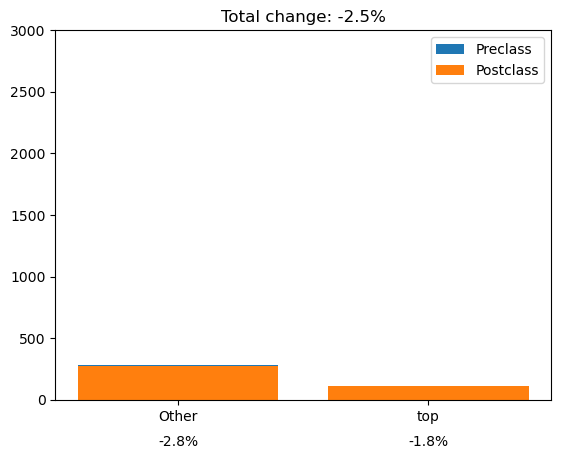

In [7]:
contexts = ["Other", "top"]

plt.bar(contexts, preclass_particles_to_check_df["Context"].value_counts()[contexts], label="Preclass")
plt.bar(contexts, postclass_particles_to_check_df["Context"].value_counts()[contexts], label="Postclass")
plt.ylim(0, 3000)

# calculate % change in each context between preclass and postclass, and total % change
preclass_context_counts = preclass_particles_to_check_df["Context"].value_counts()
postclass_context_counts = postclass_particles_to_check_df["Context"].value_counts()
# print counts
print(f"Preclass context counts: {preclass_context_counts}")
print(f"Postclass context counts: {postclass_context_counts}")
context_change = (postclass_context_counts - preclass_context_counts) / preclass_context_counts * 100
total_change = (postclass_context_counts.sum() - preclass_context_counts.sum()) / preclass_context_counts.sum() * 100
plt.title(f"Total change: {total_change:.1f}%")
for context in contexts:
    plt.text(context, -400, f"{context_change[context]:.1f}%", ha="center", va="bottom")
plt.legend()


In [121]:
tomo_list = [tomo.name[:6] for tomo in sorted(tomo_dir.glob("*.mod"))]
preclass_particles_to_check_df = pd.DataFrame()
postclass_particles_to_check_df = pd.DataFrame()
for tomo_name in tomo_list:

    preclass_particles_to_check_df = pd.concat([preclass_particles_to_check_df, preclass_particle_df[preclass_particle_df["rlnTomoName"].isin(tomo_list)]])
    postclass_particles_to_check_df = pd.concat([postclass_particles_to_check_df, postclass_particle_df[postclass_particle_df["rlnTomoName"].isin(tomo_list)]])
    
    preclass_particles_to_check_df["Context"] = None
    postclass_particles_to_check_df["Context"] = None
    top_points_file = tomo_dir / f"{tomo_name}_top.xyz" 
    top_points_df = pd.read_csv(top_points_file, delim_whitespace=True, header=None, names=["x", "y", "z"]) * binning
    increment_nm = 10
    increment_px = increment_nm * 10 / unbinned_pixel_size
    num_layers = 30
    for i in range(num_layers):
        # if the lowest point is below the bottom boundary, stop
        if top_points_df["z"].min() < 0:
            break
        
        top_points_df["z"] = top_points_df["z"] - increment_px
        print(top_points_df["z"].min())
        top_points_df = pd.concat([top_points_df, topboundary_points_df])
        top_ConvexHull = ConvexHull(top_points_df)
        for index, row in preclass_particles_to_check_df[preclass_particles_to_check_df["rlnTomoName"] == tomo_name].iterrows():
            if preclass_particles_to_check_df.loc[index, "Context"]==None:
                if point_in_ConvexHull(top_ConvexHull, row[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].values):
                    preclass_particles_to_check_df.loc[index, "Context"] = f"{i}"
        for index, row in postclass_particles_to_check_df[postclass_particles_to_check_df["rlnTomoName"] == tomo_name].iterrows():
            if postclass_particles_to_check_df.loc[index, "Context"]==None:
                if point_in_ConvexHull(top_ConvexHull, row[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].values):
                    postclass_particles_to_check_df.loc[index, "Context"] = f"{i}"

3202.621247113164
3110.242494226328
3017.8637413394918
2925.4849884526557
2833.1062355658196
2740.7274826789835
2648.3487297921474
2555.9699769053113
2463.5912240184753
2371.212471131639
2278.833718244803
2186.454965357967
2094.076212471131
2001.6974595842948
1909.3187066974588
1816.9399538106227
1724.5612009237866
1632.1824480369505
1539.8036951501144
1447.4249422632784
1355.0461893764423
1262.6674364896062
1170.28868360277
1077.909930715934
985.5311778290979
893.1524249422619
800.7736720554258
708.3949191685897
616.0161662817536
523.6374133949175
3207.621247113164


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [118]:
# print number of particles in tomo_list


Context
11    46
10    45
12    44
14    35
13    34
15    32
8     22
9     21
16    20
18    16
17    14
7     13
3     12
19    11
20    11
21     8
24     7
22     7
2      6
6      5
1      4
23     4
4      3
5      3
0      1
26     1
Name: count, dtype: int64

Context
0      1
1      4
2      6
3     12
4      3
5      3
6      5
7     13
8     22
9     21
10    45
11    46
12    44
13    34
14    35
15    32
16    20
17    14
18    16
19    11
20    11
21     8
22     7
23     4
24     7
26     1
Name: count, dtype: int64


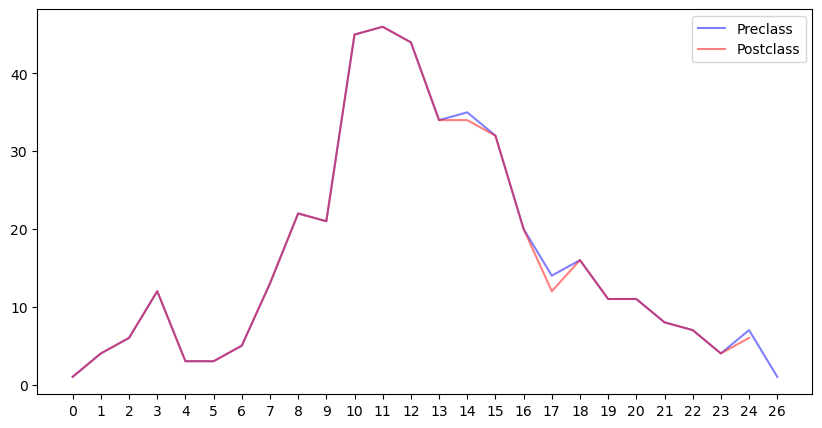

In [119]:
fig, ax = plt.subplots()
# set fig size
fig.set_size_inches(10, 5)
preclass_context_counts = preclass_particles_to_check_df["Context"].value_counts()
postclass_context_counts = postclass_particles_to_check_df["Context"].value_counts()

preclass_context_counts.sort_index(inplace=True, key=lambda x: x.astype(int))
postclass_context_counts.sort_index(inplace=True, key=lambda x: x.astype(int))
# fill in unoccupied layers
print(preclass_context_counts)

ax.plot(preclass_context_counts.index, preclass_context_counts.values,
           label="Preclass", 
           color = "blue",
           alpha = 0.5
           )
ax.plot(postclass_context_counts.index, postclass_context_counts.values, 
           label="Postclass", 
           color = "red",
           alpha = 0.5,
           )


ax.legend()